## Imports

In [1]:
import numpy as np
import pandas as pd
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow import keras
import re
import string
from matplotlib import pyplot as plt
from tensorflow.keras import layers, losses, utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import plotly.express as px 
from sklearn.decomposition import PCA

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ashwinvasan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
2022-05-16 20:59:05.431654: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Acquiring the Data

The following code is used to acquire the data:

In [2]:
train_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_train.csv?raw=true"
fake_news = pd.read_csv(train_url)

## Making a Dataset

I will write a function called `make_dataset`. This function should do two things:

1. Remove stopwords from the article text and title. A stopword is a word that is usually considered to be uninformative, such as “the,” “and,” or “but.”
2. Construct and return a tf.data.Dataset with two inputs and one output. The input should be of the form `(title, text)`, and the output should consist only of the `fake` column.

In [7]:
def make_dataset(df):
    stop_words = stopwords.words('english')
    df['title'] = df["title"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    df['text'] = df["text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    # create Dataset using title and text without stopwords
    my_data_set = tf.data.Dataset.from_tensor_slices( #process it into a tensorflow data
      (
        {
            "title" : df[["title"]], 
            "text" : df[["text"]]
        }, 
        {
            "fake" : df["fake"]
        }
      )
    )
    # set batch to 100 for faster runtime 
    my_data_set.batch(100)
    return my_data_set

In [8]:
fake_news = make_dataset(fake_news)

2022-05-16 21:03:31.012068: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Creating Validation data

After constructing my primary `Dataset`, I will split off 20% of it to use for validation.

In [9]:
# random shuffle of the data
fake_news = fake_news.shuffle(buffer_size = len(fake_news))
# 70% train, 20% validation, 10% test
train_size = int(0.7*len(fake_news)) 
val_size = int(0.2*len(fake_news))

train = fake_news.take(train_size)
val = fake_news.skip(train_size).take(val_size) 
test = fake_news.skip(train_size + val_size)

### Finding the Base Rate

In [12]:
iterator= train.map(lambda x, fake: fake).as_numpy_iterator()
count = 0

for i in range(len(train)):
  # adds 1 if article is fake and 0 if article is real
  count += iterator.next()["fake"]
print(count)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
8248


In [13]:
base_rate = count/len(train)
base_rate

0.524882270586738

We can see that the base rate of the training dataset is approximately 0.526. This means that if the model were to solely guess fake news, then it would be correct ~52.6% of the time.

### Text Vectorization

We will create a text vectorization that will be used when creating the models in the following parts. This layer should be adapted to both the article title and article text.

In [14]:
#preparing a text vectorization layer for tf model
size_vocabulary = 2000

def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_punctuation = tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation 

vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary, # only consider this many words
    output_mode='int',
    output_sequence_length=500) 

vectorize_layer.adapt(train.map(lambda x, y: x["title"]))
vectorize_layer.adapt(train.map(lambda x, y: x["text"]))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity t

## Creating Models

In my first model, I will use **only the article title** as an input.

In [15]:
title_input = keras.Input(
    shape=(1,),
    name = "title", # same name as the dictionary key in the dataset
    dtype = "string"
)

In [ ]:
title_features = vectorize_layer(title_input) # apply this "function TextVectorization layer" to title_input
title_features = layers.Embedding(size_vocabulary, output_dim = 3, name="embedding")(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.GlobalAveragePooling1D()(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.Dense(32, activation='relu')(title_features)

output = layers.Dense(2, name = "fake")(title_features)

In [ ]:
model1 = keras.Model(
    inputs = title_input,
    outputs = output
)

model1.compile(optimizer = "adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

history = model1.fit(train, 
                     validation_data=val,
                     epochs = 25)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['text'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


15714/15714 [==============================] - 103s 6ms/step - loss: 0.3699 - accuracy: 0.8110 - val_loss: 0.1385 - val_accuracy: 0.9472
Epoch 2/25
15714/15714 [==============================] - 98s 6ms/step - loss: 0.1277 - accuracy: 0.9511 - val_loss: 0.0898 - val_accuracy: 0.9717
Epoch 3/25
15714/15714 [==============================] - 99s 6ms/step - loss: 0.1119 - accuracy: 0.9596 - val_loss: 0.0606 - val_accuracy: 0.9811
Epoch 4/25
15714/15714 [==============================] - 96s 6ms/step - loss: 0.1020 - accuracy: 0.9627 - val_loss: 0.0567 - val_accuracy: 0.9804
Epoch 5/25
15714/15714 [==============================] - 96s 6ms/step - loss: 0.0946 - accuracy: 0.9640 - val_loss: 0.0542 - val_accuracy: 0.9788
Epoch 6/25
15714/15714 [==============================] - 96s 6ms/step - loss: 0.0951 - accuracy: 0.9649 - val_loss: 0.0806 - val_accuracy: 0.9717
Epoch 7/25
15714/15714 [==============================] - 92s 6ms/step - loss: 0.0902 - accuracy: 0.9665 - val_loss: 0.0398 - va

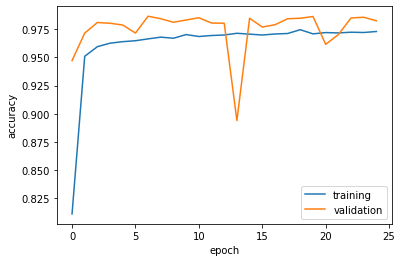

In [ ]:
# plot training and validation accuracy across epochs
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

In my second model, I will use **only the article text** as an input.

In [16]:
text_input = keras.Input(
    shape=(1,),
    name = "text", # same name as the dictionary key in the dataset
    dtype = "string"
)

In [27]:
text_features = vectorize_layer(text_input) # apply this "function TextVectorization layer" to text_input
text_features = layers.Embedding(size_vocabulary, output_dim = 3, name="embedding")(text_features)
text_features = layers.Dropout(0.2)(text_features)
text_features = layers.GlobalAveragePooling1D()(text_features)
text_features = layers.Dropout(0.2)(text_features)
text_features = layers.Dense(32, activation='relu')(text_features)

output = layers.Dense(2, name = "fake")(text_features)

In [28]:
model2 = keras.Model(
    inputs = text_input,
    outputs = output
)

model2.compile(optimizer = "adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

history = model2.fit(train, 
                     validation_data=val,
                     epochs = 25)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['title'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


15714/15714 [==============================] - 68s 4ms/step - loss: 0.2107 - accuracy: 0.9164 - val_loss: 0.0957 - val_accuracy: 0.9775
Epoch 2/25
15714/15714 [==============================] - 64s 4ms/step - loss: 0.1047 - accuracy: 0.9646 - val_loss: 0.0685 - val_accuracy: 0.9826
Epoch 3/25
15714/15714 [==============================] - 62s 4ms/step - loss: 0.0881 - accuracy: 0.9709 - val_loss: 0.0539 - val_accuracy: 0.9828
Epoch 4/25
15714/15714 [==============================] - 62s 4ms/step - loss: 0.0796 - accuracy: 0.9715 - val_loss: 0.0460 - val_accuracy: 0.9855
Epoch 5/25
15714/15714 [==============================] - 62s 4ms/step - loss: 0.0724 - accuracy: 0.9740 - val_loss: 0.0455 - val_accuracy: 0.9884
Epoch 6/25
15714/15714 [==============================] - 62s 4ms/step - loss: 0.0694 - accuracy: 0.9765 - val_loss: 0.0420 - val_accuracy: 0.9911
Epoch 7/25
15714/15714 [==============================] - 63s 4ms/step - loss: 0.0663 - accuracy: 0.9767 - val_loss: 0.0405 - val

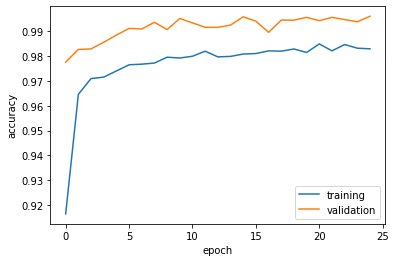

In [29]:
# plot training and validation accuracy across epochs
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

In my third model, I will use **both the article title and the article text** as input.

In [17]:
# vectorizing input for both title and text
title_features = vectorize_layer(title_input)
text_features = vectorize_layer(text_input)

# create a shared embedding layer for title and text
shared_embedding = layers.Embedding(size_vocabulary, 3, name = "embedding")
title_features = shared_embedding(title_features)
text_features = shared_embedding(text_features)

# add different layers for both features
title_features = layers.Dropout(0.2)(title_features)
text_features = layers.Dropout(0.2)(text_features)
title_features = layers.GlobalAveragePooling1D()(title_features)
text_features = layers.GlobalAveragePooling1D()(text_features)
title_features = layers.Dropout(0.2)(title_features)
text_features = layers.Dropout(0.2)(text_features)
title_features = layers.Dense(32, activation='relu')(title_features)
text_features = layers.Dense(32, activation='relu')(text_features)

# concatenate title and text features
features = layers.concatenate([title_features, text_features], axis = 1)
features = layers.Dense(32, activation='relu')(features)

output = layers.Dense(2, name = "fake")(features)

In [24]:
model3 = keras.Model(
    inputs = [title_input, text_input],
    outputs = output
)

model3.compile(optimizer = "adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

history = model3.fit(train, 
                     validation_data=val,
                     epochs = 25)

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ValueError: slice index 0 of dimension 0 out of bounds. for '{{node strided_slice}} = StridedSlice[Index=DT_INT32, T=DT_INT32, begin_mask=0, ellipsis_mask=0, end_mask=0, new_axis_mask=0, shrink_axis_mask=1](Shape, strided_slice/stack, strided_slice/stack_1, strided_slice/stack_2)' with input shapes: [0], [1], [1], [1] and with computed input tensors: input[1] = <0>, input[2] = <1>, input[3] = <1>.

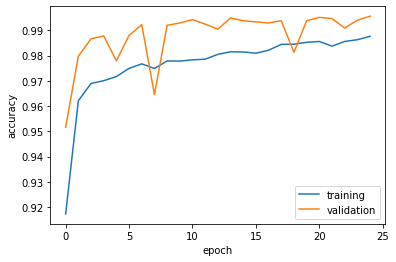

In [35]:
# plot training and validation accuracy across epochs
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

After analyzing the performance of my models, we see that all three models were successful. It is clear that the model that uses just **article text** and the model that uses both **article title and article text** are most successful. However, it appears that overfitting could be more of an issue with the model that solely used **article text**. Thus, algorithms should use both title and text when seeking to detect fake news.



## Evaluating the Final Model

In [36]:
test_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_test.csv?raw=true"
test_df = pd.read_csv(test_url)
test_data = make_dataset(test_df)

# evaluate the best model on the test dataset
model3.evaluate(test_data)

22449/22449 [==============================] - 60s 3ms/step - loss: 0.0611 - accuracy: 0.9814


[0.06108703091740608, 0.981380045413971]

My final model which includes both the **article title and article text** has 98.14% accuracy on the test data. Thus, if we used my model as a fake news detector, it would be right approximately 98.14% of the time.

## Creating an Embedding Visualization

In [23]:
weights = model3.get_layer('embedding').get_weights()[0] # get the weights from the embedding layer
vocab = vectorize_layer.get_vocabulary()                # get the vocabulary from our data prep for later

pca = PCA(n_components=2)
weights = pca.fit_transform(weights)

embedding_df = pd.DataFrame({
    'word' : vocab, 
    'x0'   : weights[:,0],
    'x1'   : weights[:,1]
})

fig = px.scatter(embedding_df, 
                 x = "x0", 
                 y = "x1", 
                 size = list(np.ones(len(embedding_df))),
                 size_max = 10,
                 hover_name = "word")

fig.show()

Based on my embedding visualization, we can see that `conservative`, `economic`, `political`, `leader`, and `federal` all lie closely to one another towards the center of the plot. This makes sense because all of the words are related to the government and the overall status and views of people.